In [14]:
# import standard modules
import time
import math
import h5py
import os,glob
import numpy as np
from tqdm import tqdm

import torch
import torch.nn.utils as utils
from torch.utils.data import DataLoader,TensorDataset
from torch.optim.lr_scheduler import StepLR

from dataload import process_data
import matplotlib.pyplot as plt
import json


In [15]:
path='/Users/yangkai/Works/SPIN4D/muram/muram_inv_630_sir/'
files=path+'muram_tau_layers_200g.h5'

### Crop data used for testing
#### The original data is from SPIN4D project SSD simulation, for the case SSD 200 G case, with file number: 097162
#### The file here is the magnetic field mapped on to several optical isosurfaces, with sampling step $\delta \tau$=0.1
#### The data used here with $\tau$ values range from 0 to -3.1

In [16]:
istart=3
hsize=32
with h5py.File(files,'r') as f:
    bx = f['bx'][:][:,:,istart:istart+hsize]
    by = f['by'][:][:,:,istart:istart+hsize]
    bz = f['bz'][:][:,:,istart:istart+hsize]
    x3d = f['x3d'][:][:,:,istart:istart+hsize]
    y3d = f['y3d'][:][:,:,istart:istart+hsize]
    trueZ = f['tz3d'][:][:,:,istart:istart+hsize]


#### trueZ is the true geometric height for each $\tau$ isosurfaces obtained from the simulation.

In [17]:
xstart=368
xend=896

ystart=112 
yend=640

In [18]:
subbx=bx[xstart:xend,ystart:yend,:]
subby=by[xstart:xend,ystart:yend,:]
subbz=bz[xstart:xend,ystart:yend,:]

subx3d=x3d[xstart:xend,ystart:yend,:]
suby3d=y3d[xstart:xend,ystart:yend,:]
subtrueZ=trueZ[xstart:xend,ystart:yend,:]

Text(0, 0.5, 'Y (pixels)')

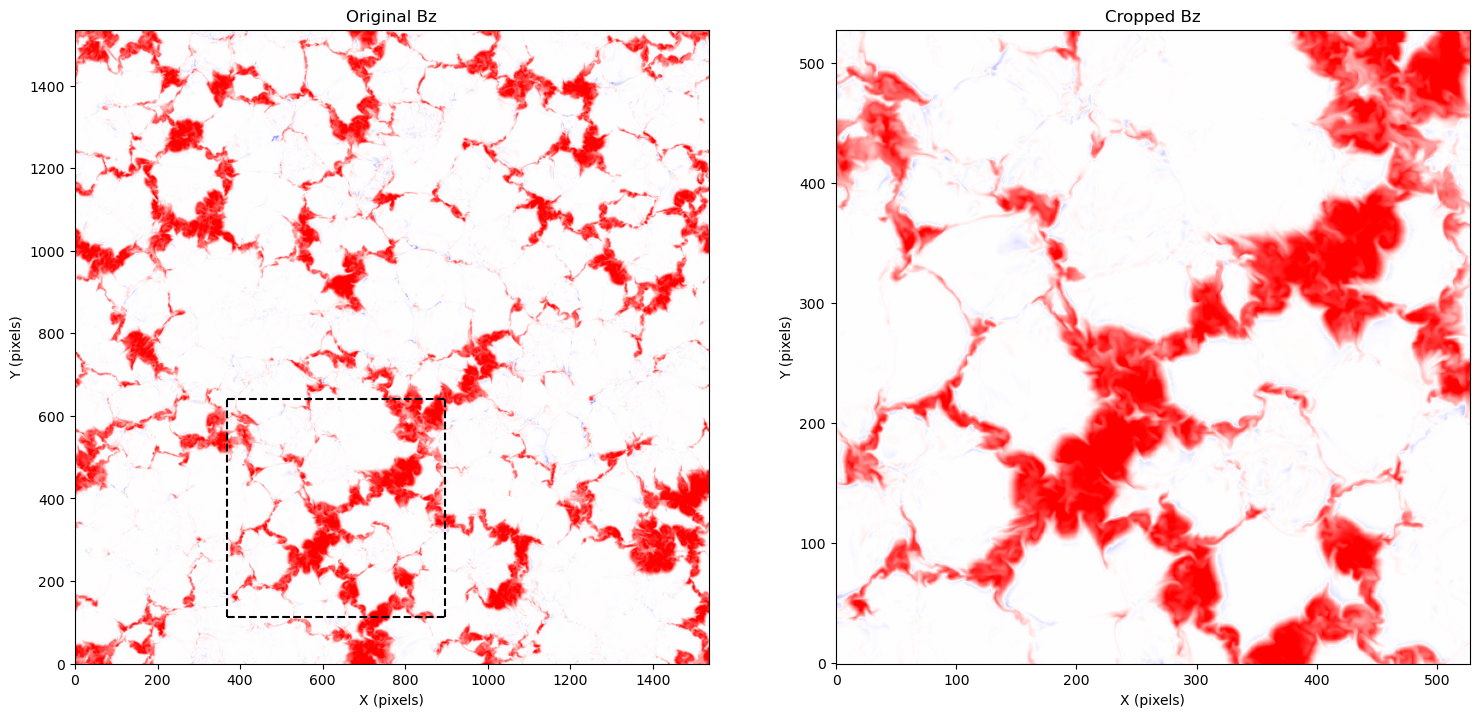

In [19]:
fig,axs=plt.subplots(1,2,figsize=(18,10))
axs[0].imshow(bz[...,10].T,origin='lower',vmin=-5e2,vmax=5e2,cmap='bwr')
axs[1].imshow(subbz[...,10].T,origin='lower',vmin=-5e2,vmax=5e2,cmap='bwr')

axs[0].plot([xstart,xstart],[ystart,yend],'k--')
axs[0].plot([xend,xend],[ystart,yend],'k--')
axs[0].plot([xstart,xend],[ystart,ystart],'k--')
axs[0].plot([xstart,xend],[yend,yend],'k--')

axs[0].set_title('Original Bz')
axs[1].set_title('Cropped Bz')

axs[0].set_xlabel('X (pixels)')
axs[0].set_ylabel('Y (pixels)')
axs[1].set_xlabel('X (pixels)')
axs[1].set_ylabel('Y (pixels)')

### The data will be further split into 16 batches for training.
#### with core size 64 and margin pad size 16 pixels on each side.

In [20]:
size=64
pad=16

Text(0, 0.5, 'Y (pixels)')

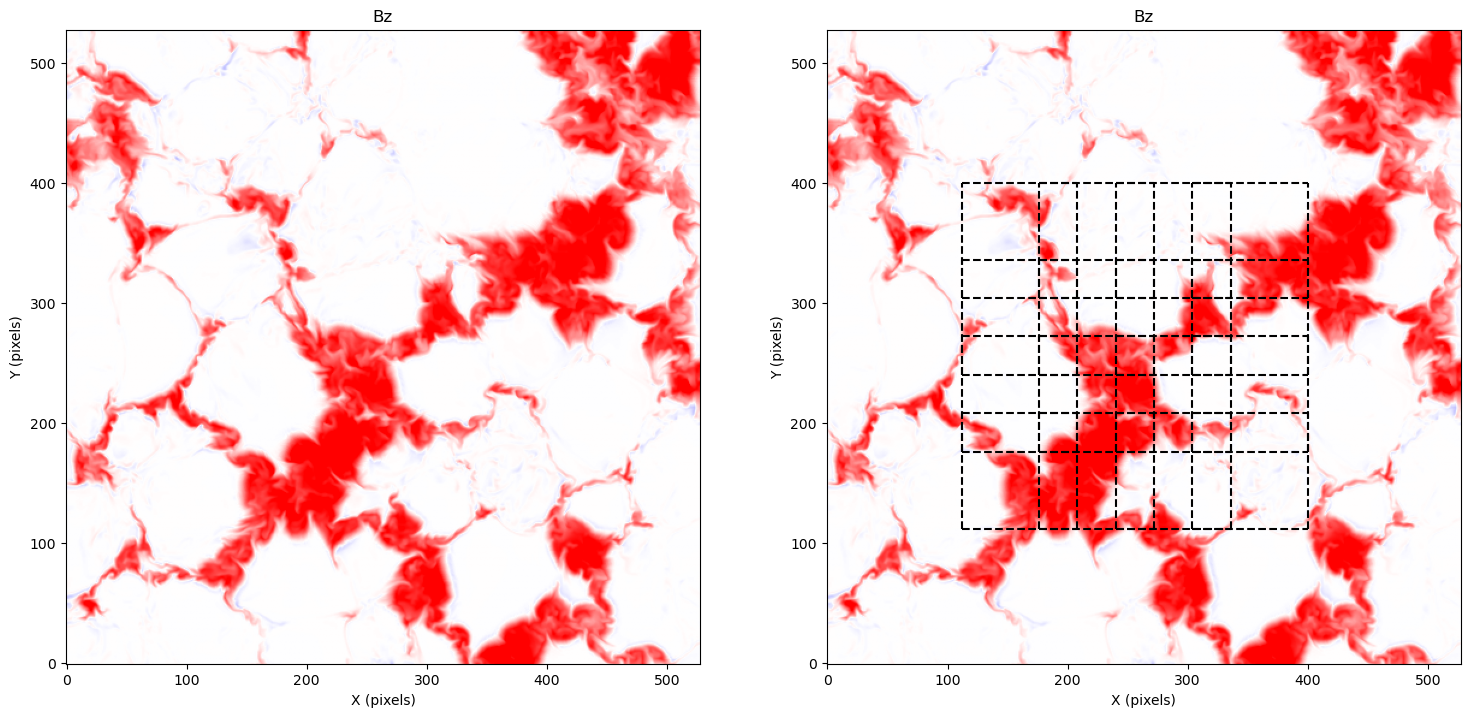

In [21]:
fig,axs=plt.subplots(1,2,figsize=(18,10))
axs[0].imshow(subbz[...,10].T,origin='lower',vmin=-5e2,vmax=5e2,cmap='bwr')
axs[1].imshow(subbz[...,10].T,origin='lower',vmin=-5e2,vmax=5e2,cmap='bwr')

for ix in range(4):
    for iy in range(4):
        idx=ix+2
        idy=iy+2
        xs,xe=idx*size-pad,(idx+1)*size+pad
        ys,ye=idy*size-pad,(idy+1)*size+pad

        axs[1].plot([xs,xe],[ys,ys],'k--')
        axs[1].plot([xs,xe],[ye,ye],'k--')
        axs[1].plot([xs,xs],[ys,ye],'k--')
        axs[1].plot([xe,xe],[ys,ye],'k--')


axs[0].set_title('Bz')
axs[1].set_title('Bz')

axs[0].set_xlabel('X (pixels)')
axs[0].set_ylabel('Y (pixels)')
axs[1].set_xlabel('X (pixels)')
axs[1].set_ylabel('Y (pixels)')

### Visualization of Bx on $\tau=1.0$ for each batch

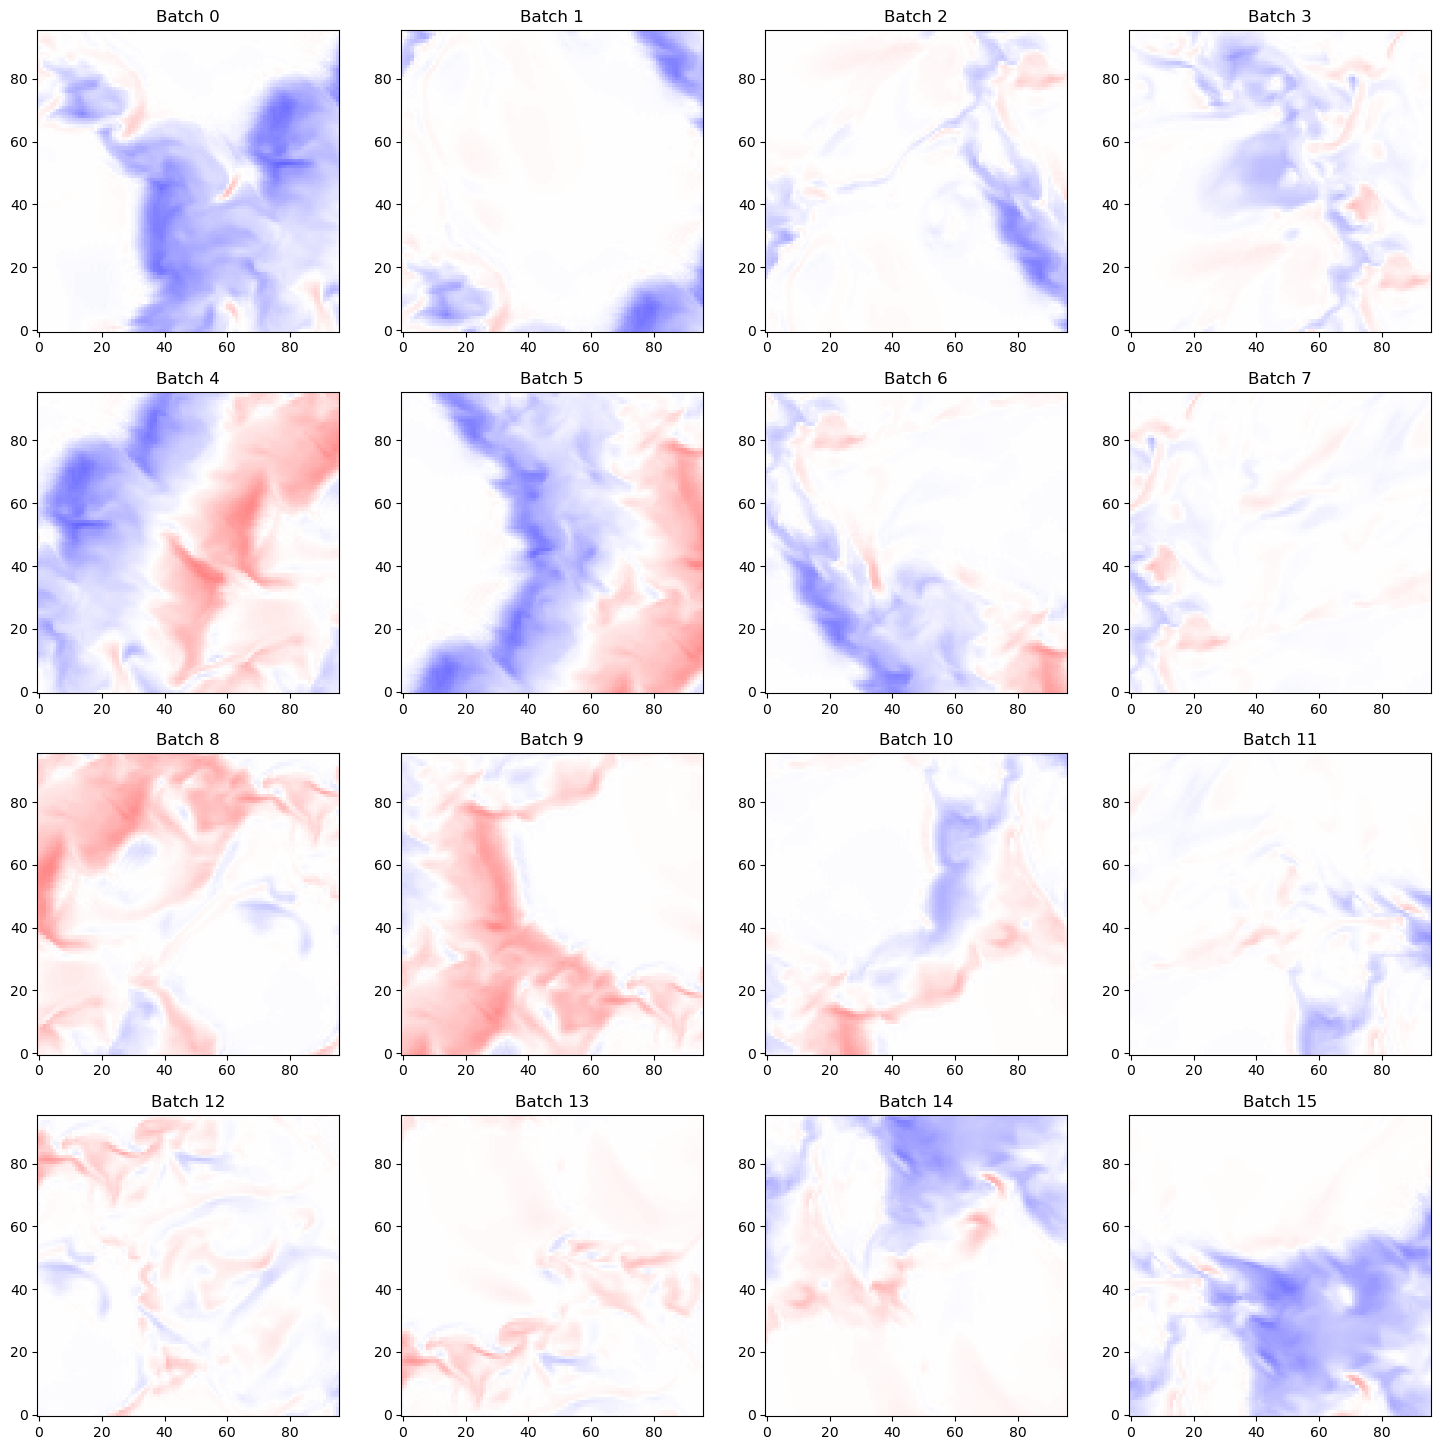

In [22]:
fig,axs=plt.subplots(4,4,figsize=(18,18))

for ix in range(4):
    for iy in range(4):
        idx=ix+2
        idy=iy+2
        xs,xe=idx*size-pad,(idx+1)*size+pad
        ys,ye=idy*size-pad,(idy+1)*size+pad
        axs[ix,iy].imshow(subbx[xs:xe,ys:ye,10].T,origin='lower',vmin=-5e2,vmax=5e2,cmap='bwr')
        axs[ix,iy].set_title('Batch '+str(ix*4+iy))

### Visualization of By on $\tau=1.0$ for each batch

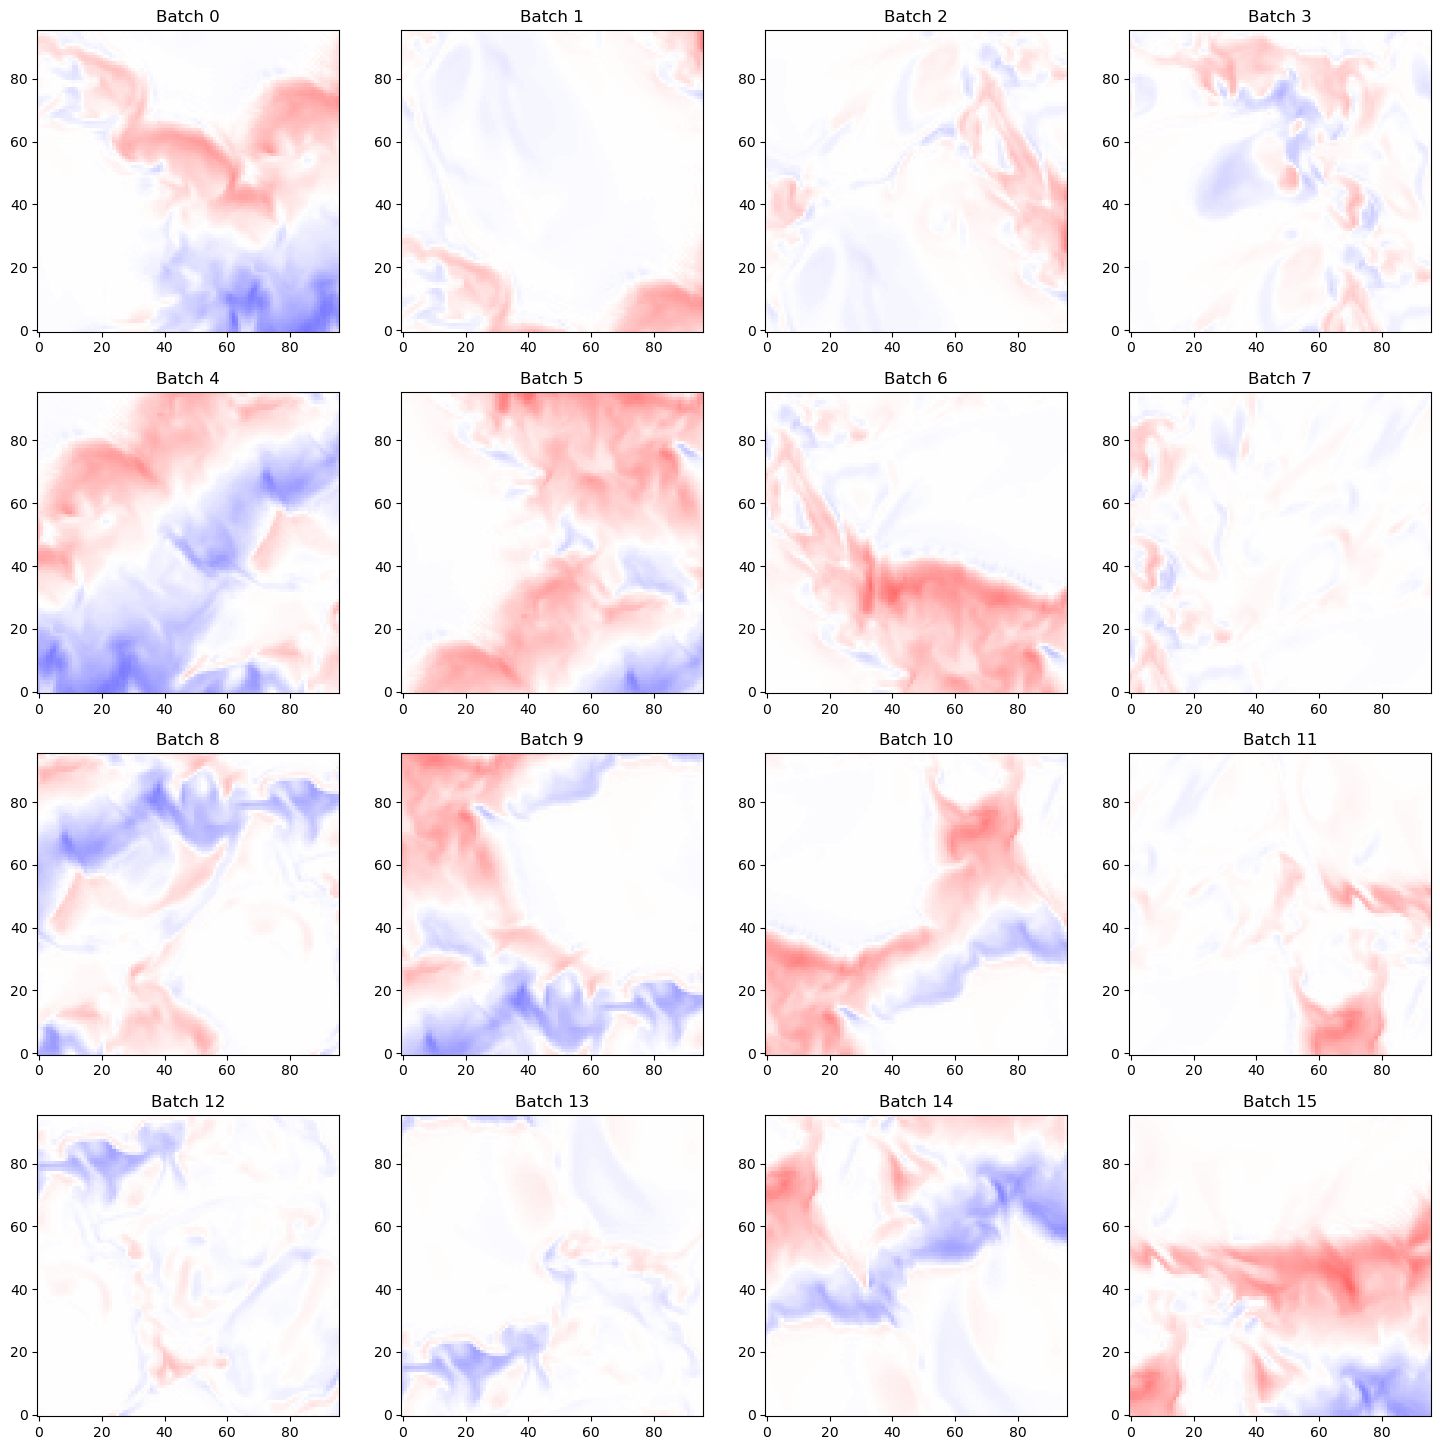

In [23]:
fig,axs=plt.subplots(4,4,figsize=(18,18))

for ix in range(4):
    for iy in range(4):
        idx=ix+2
        idy=iy+2
        xs,xe=idx*size-pad,(idx+1)*size+pad
        ys,ye=idy*size-pad,(idy+1)*size+pad
        axs[ix,iy].imshow(subby[xs:xe,ys:ye,10].T,origin='lower',vmin=-5e2,vmax=5e2,cmap='bwr')
        axs[ix,iy].set_title('Batch '+str(ix*4+iy))

### Visualization of Bz on $\tau=1.0$ for each batch

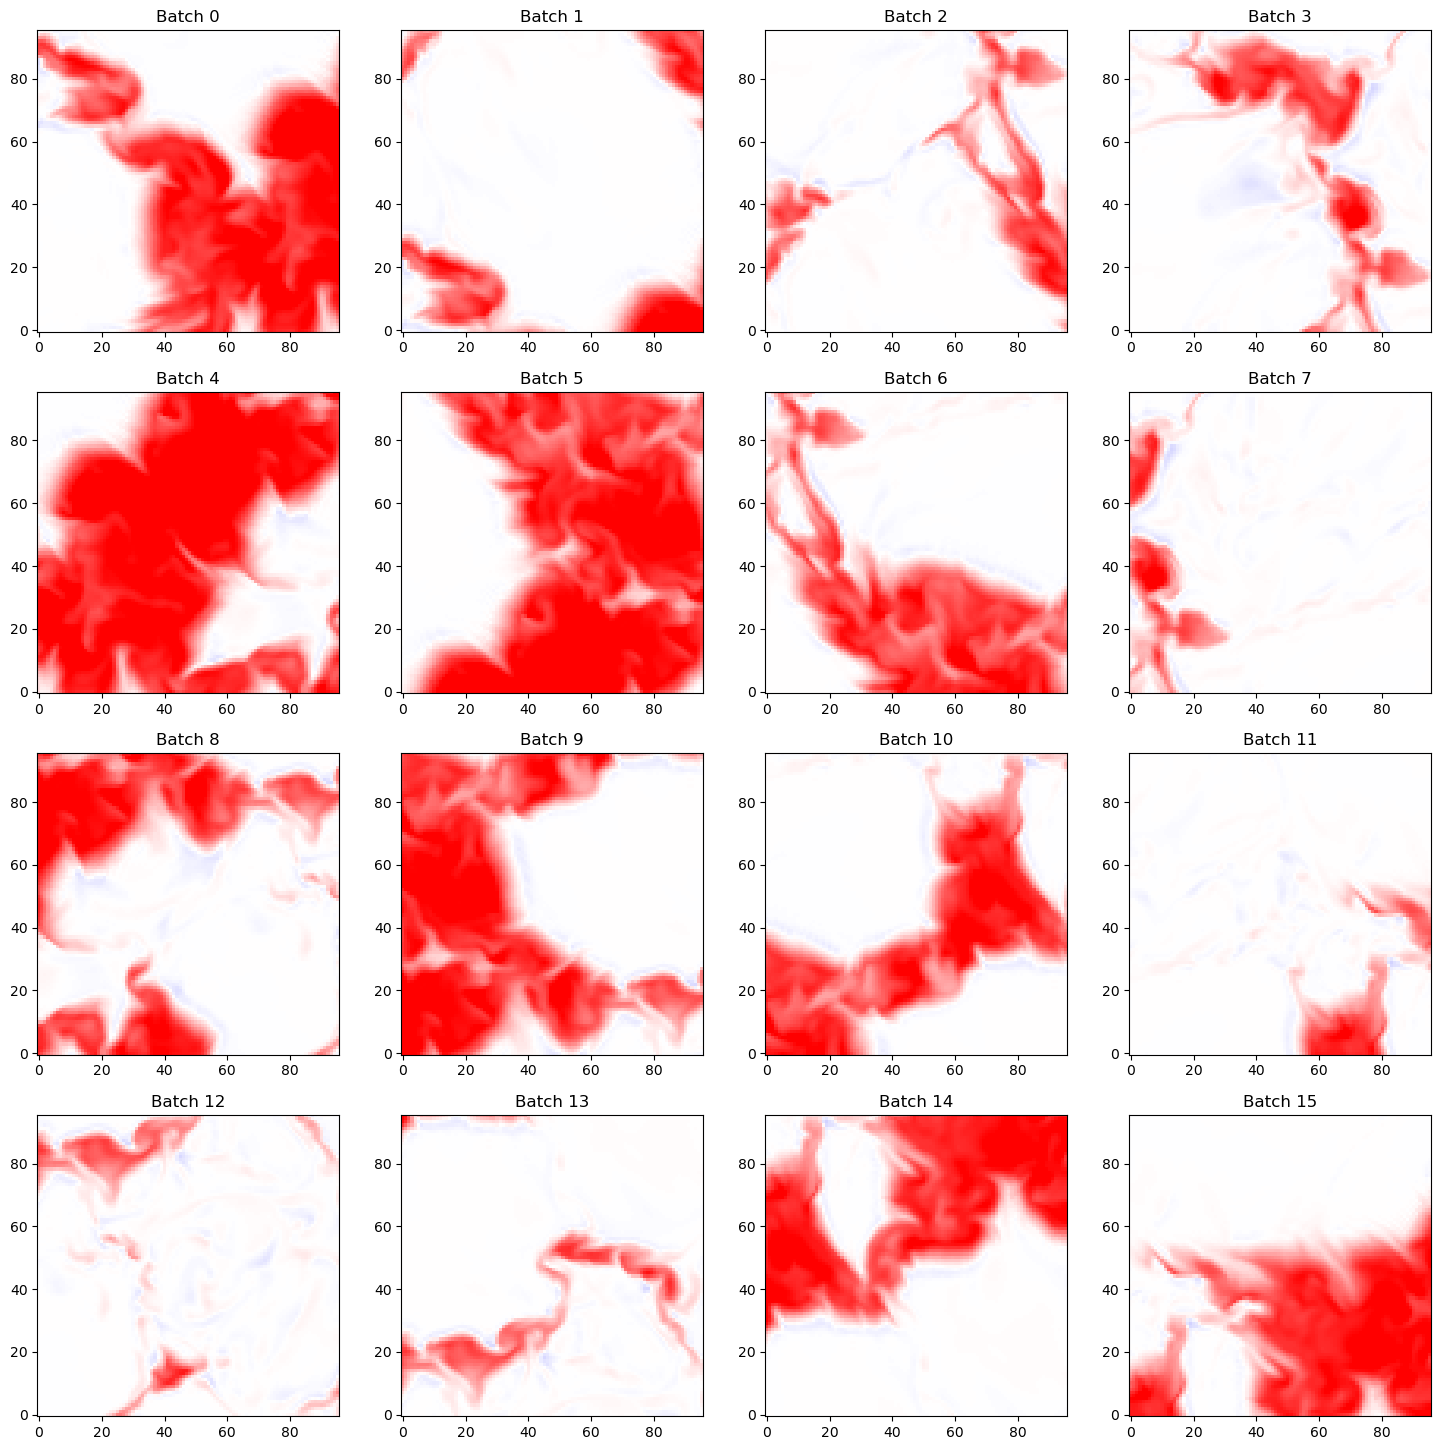

In [24]:
fig,axs=plt.subplots(4,4,figsize=(18,18))

for ix in range(4):
    for iy in range(4):
        idx=ix+2
        idy=iy+2
        xs,xe=idx*size-pad,(idx+1)*size+pad
        ys,ye=idy*size-pad,(idy+1)*size+pad
        axs[ix,iy].imshow(subbz[xs:xe,ys:ye,10].T,origin='lower',vmin=-5e2,vmax=5e2,cmap='bwr')
        axs[ix,iy].set_title('Batch '+str(ix*4+iy))

### Visualization of Z on $\tau=1.0$ for each batch

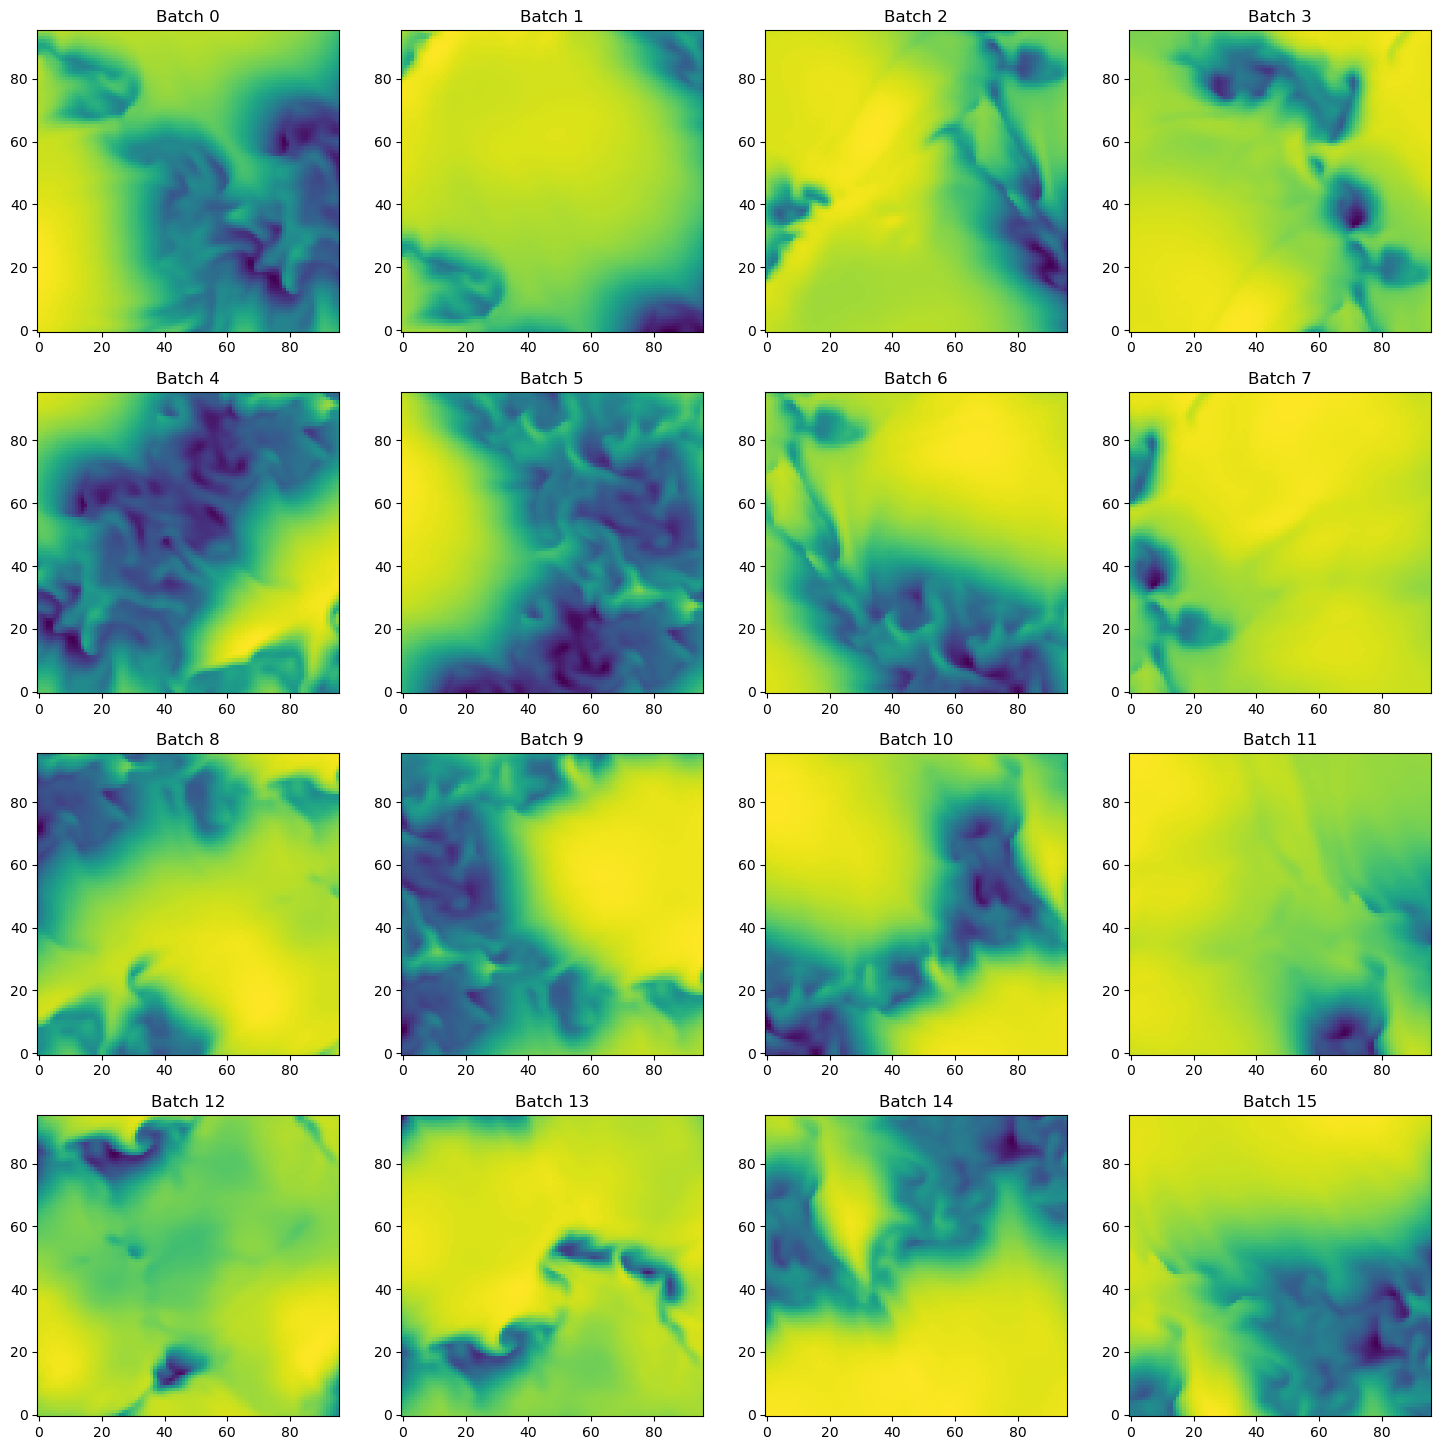

In [25]:
fig,axs=plt.subplots(4,4,figsize=(18,18))

for ix in range(4):
    for iy in range(4):
        idx=ix+2
        idy=iy+2
        xs,xe=idx*size-pad,(idx+1)*size+pad
        ys,ye=idy*size-pad,(idy+1)*size+pad
        axs[ix,iy].imshow(subtrueZ[xs:xe,ys:ye,10].T,origin='lower')
        axs[ix,iy].set_title('Batch '+str(ix*4+iy))

In [26]:
with h5py.File('train_plage.h5','w') as f:
    f.create_dataset('bx',data=subbx)
    f.create_dataset('by',data=subby)
    f.create_dataset('bz',data=subbz)
    # f.create_dataset('x3d',data=subx3d)
    # f.create_dataset('y3d',data=suby3d)
    f.create_dataset('tz3d',data=subtrueZ)